**<h1 align="center">Text Mining</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

<a class="anchor" id="chapter1"></a>

# 1. Imports

</a>

In [1]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
from tqdm import tqdm

In [4]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer, PorterStemmer

In [5]:
import gensim
from gensim.models import Word2Vec

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

In [7]:
# Set the style for seaborn
sns.set(style="white")

In [8]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

In [9]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [10]:
# Set id as index
df_test.set_index('id', inplace=True)

In [11]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [12]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

In [13]:
df_train["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [14]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

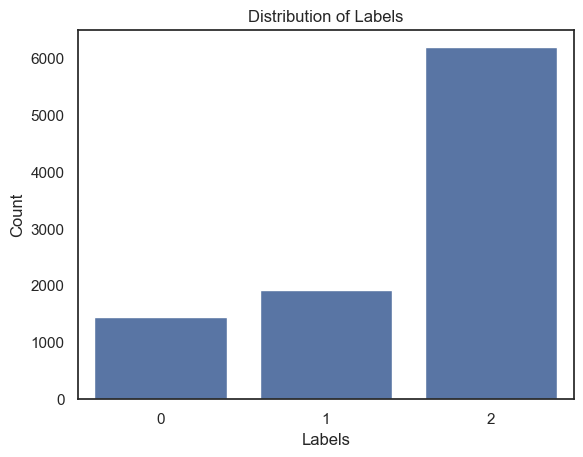

In [15]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

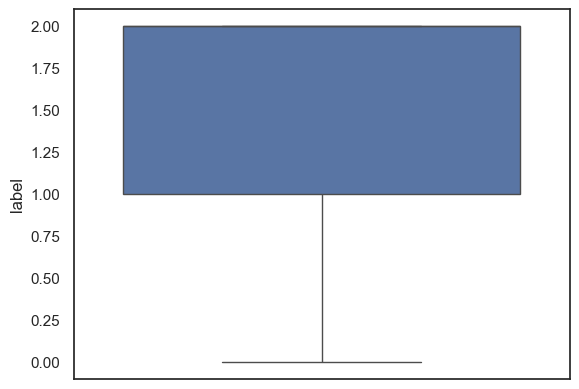

In [16]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

In [17]:
# Fetch wordcount for each abstract
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [18]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

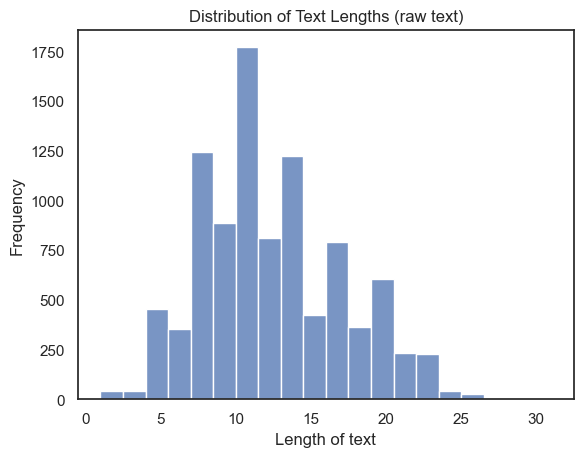

In [19]:
# Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [20]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

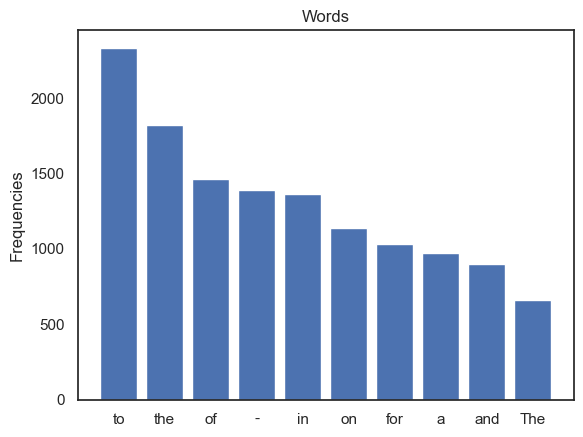

In [21]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

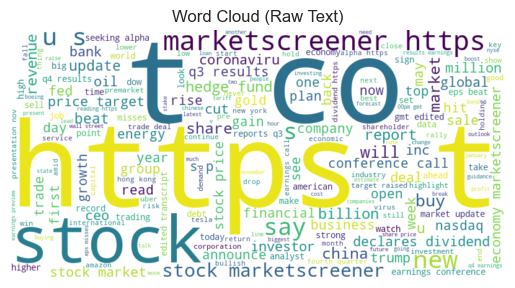

In [22]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

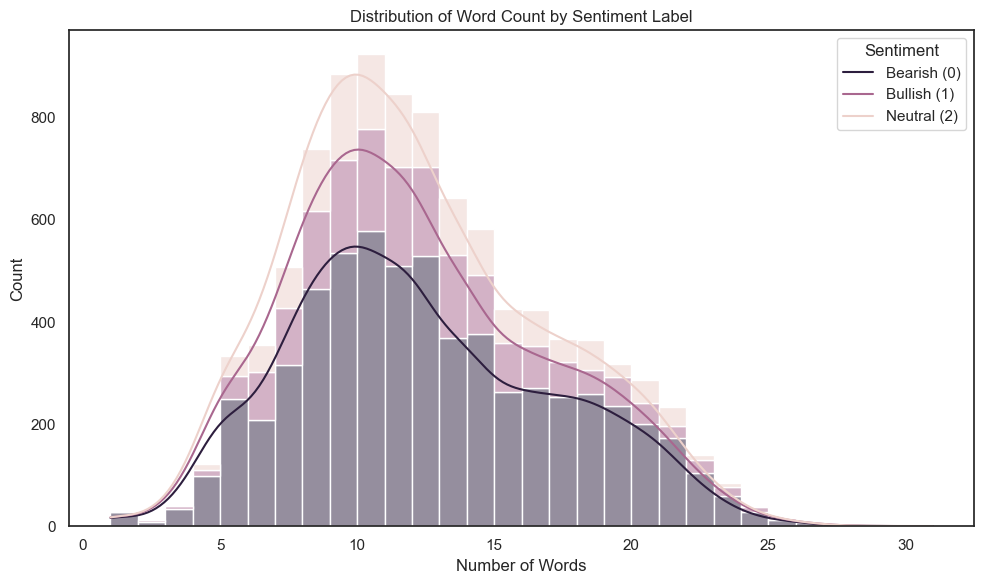

In [23]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

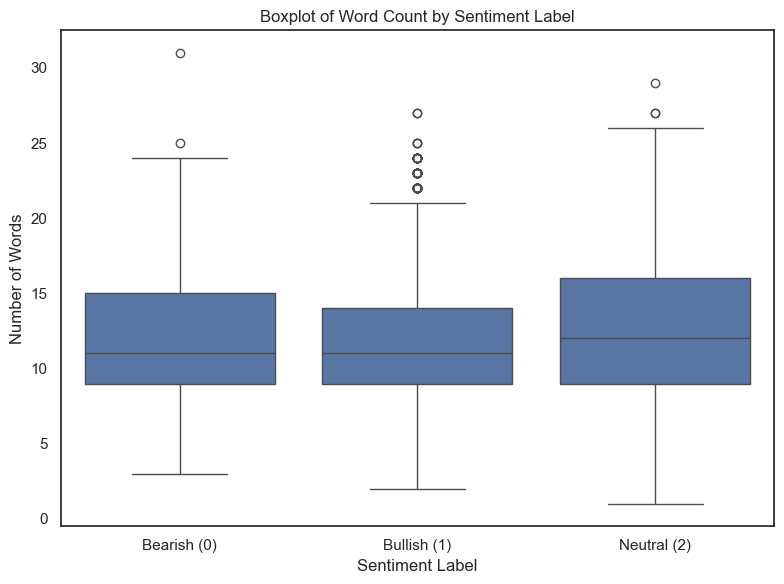

In [24]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [25]:
# Simple text cleaner
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # keep only letters
    return text

# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [26]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

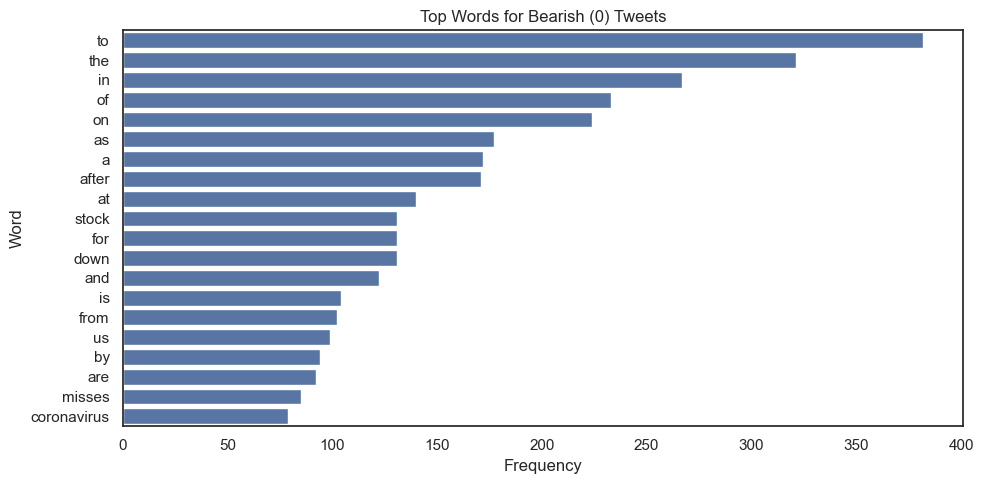

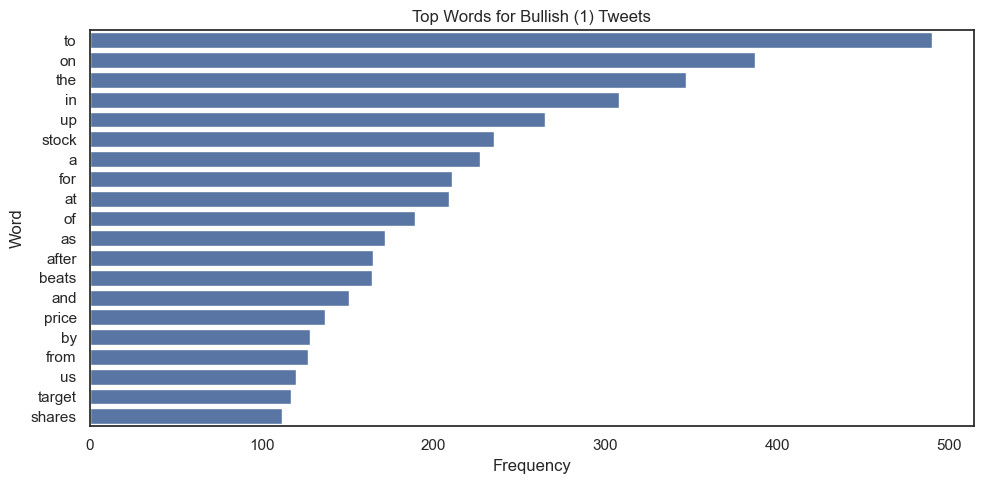

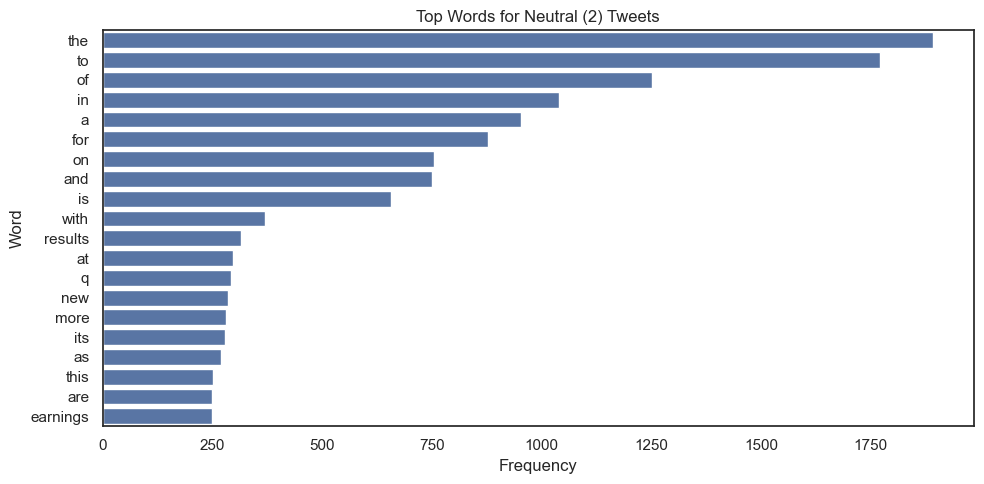

In [27]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [28]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

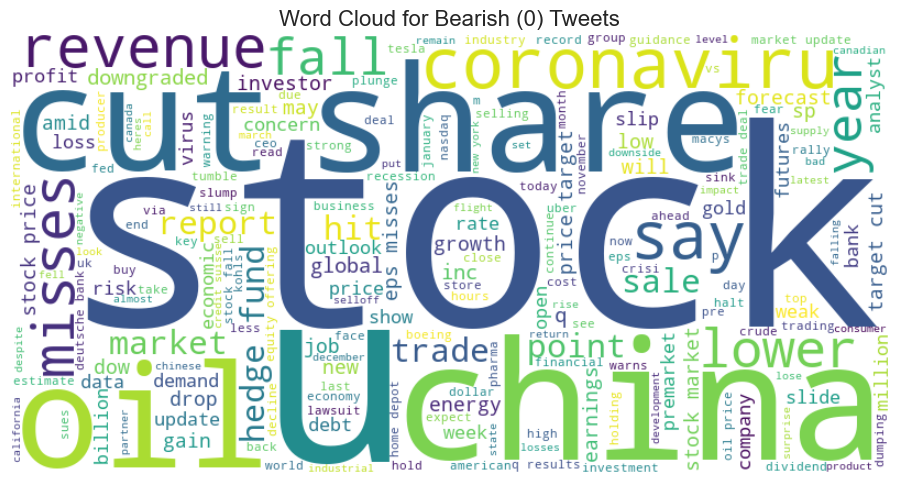

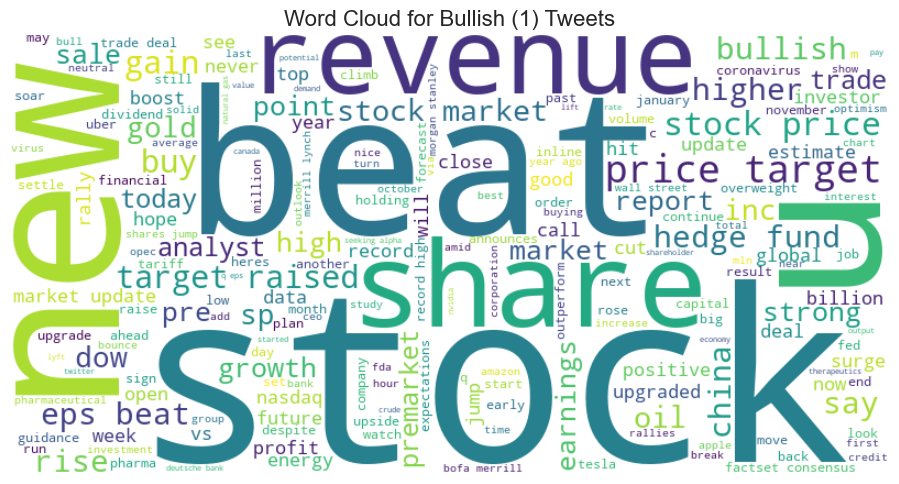

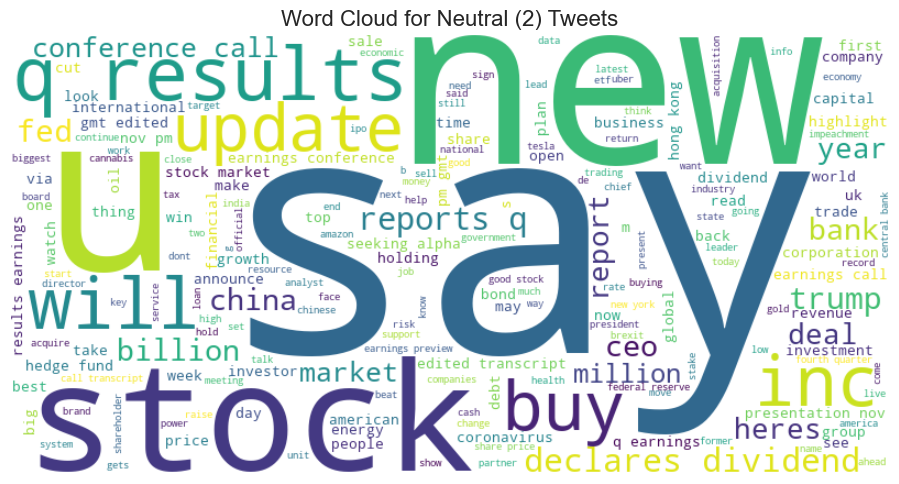

In [29]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

In [30]:
# Create a character count column
df_train['char_count'] = df_train['text'].apply(len)

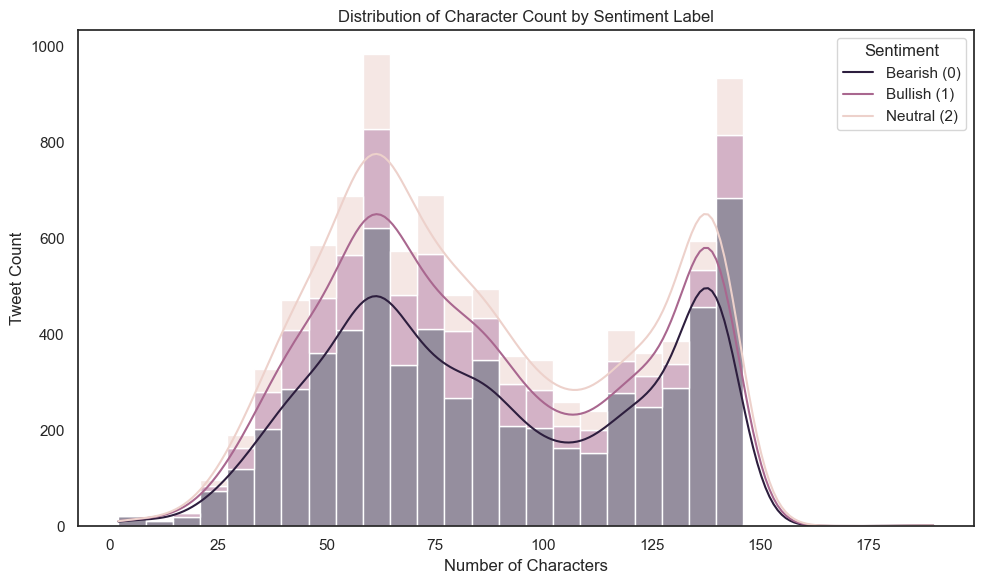

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

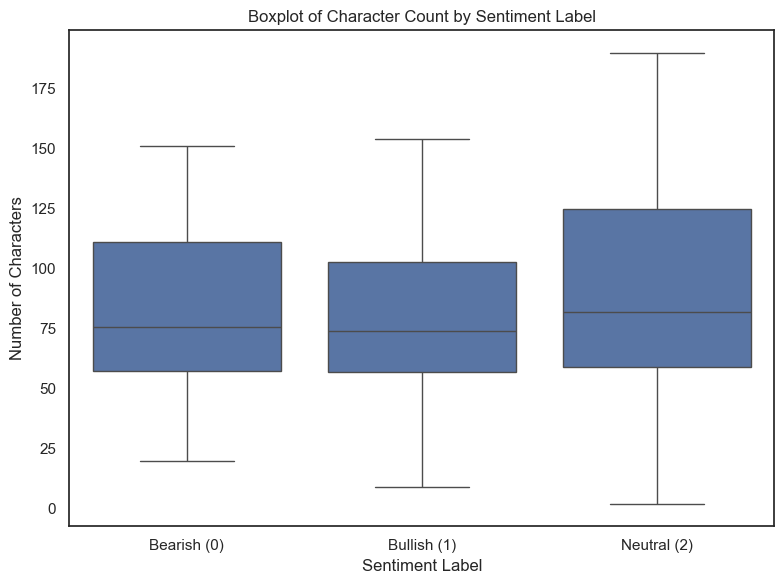

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [33]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [34]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

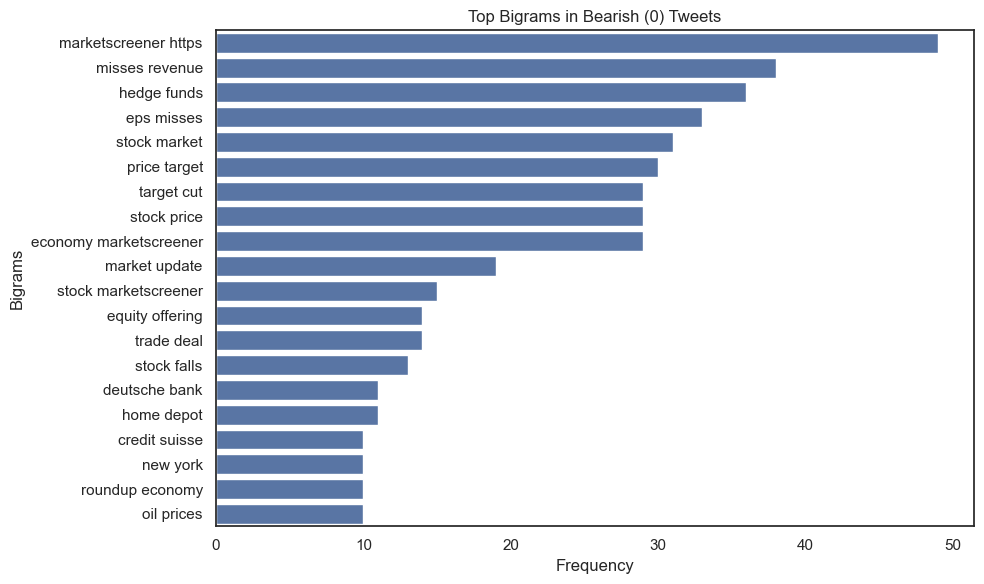

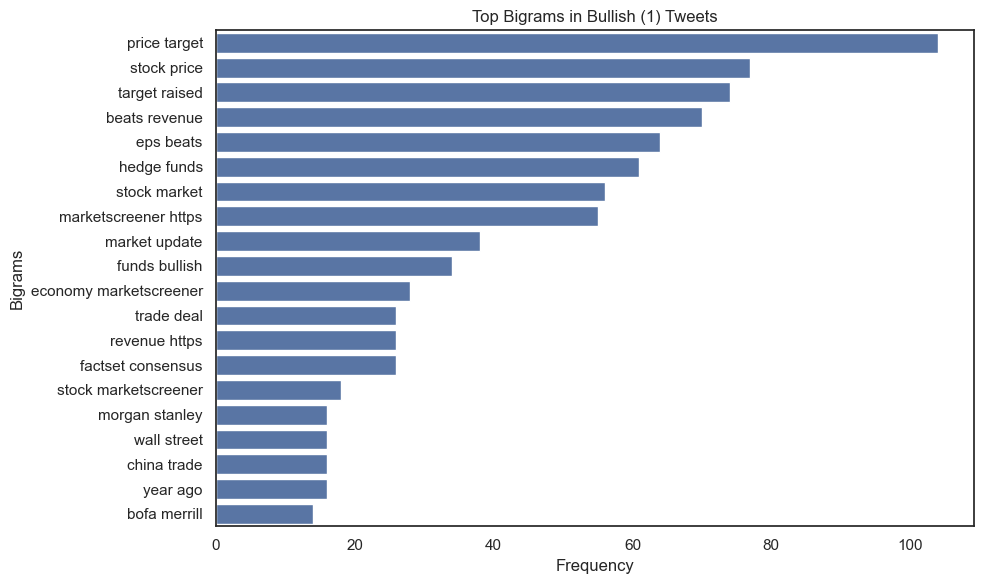

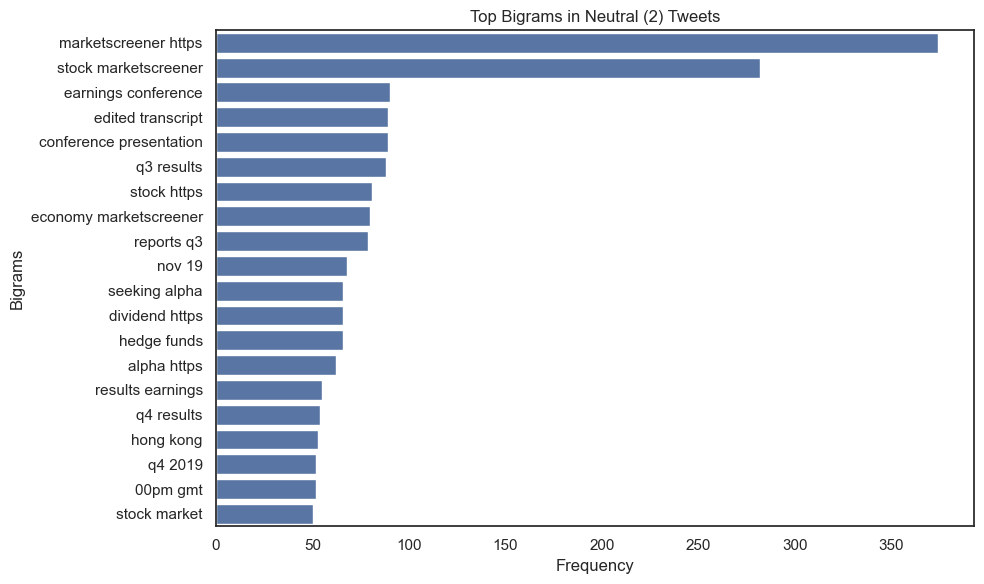

In [35]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

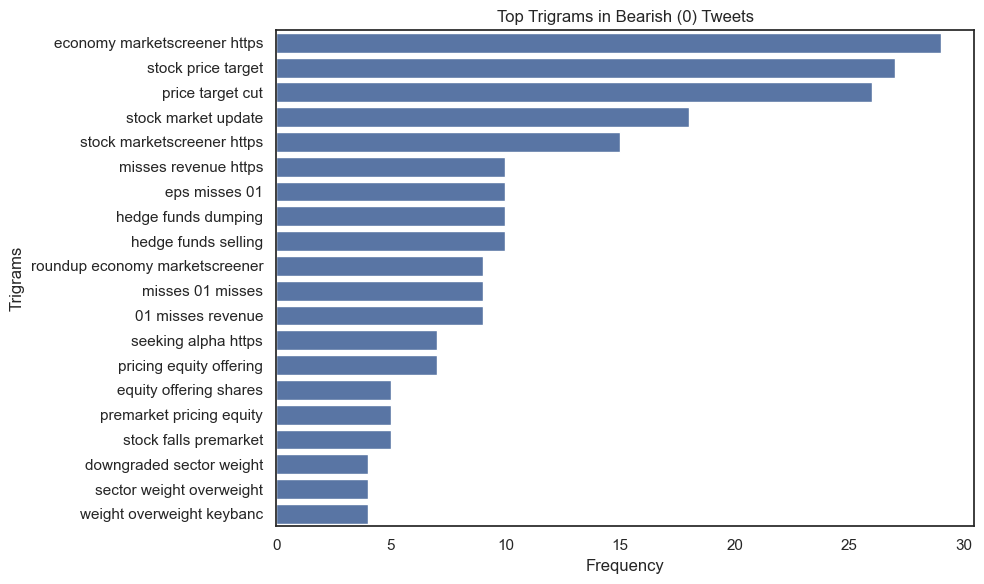

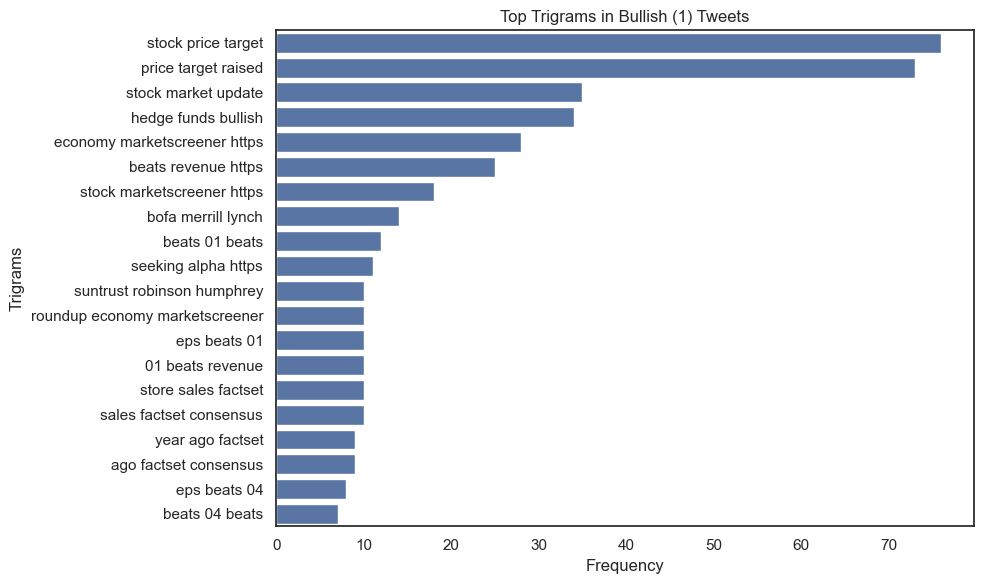

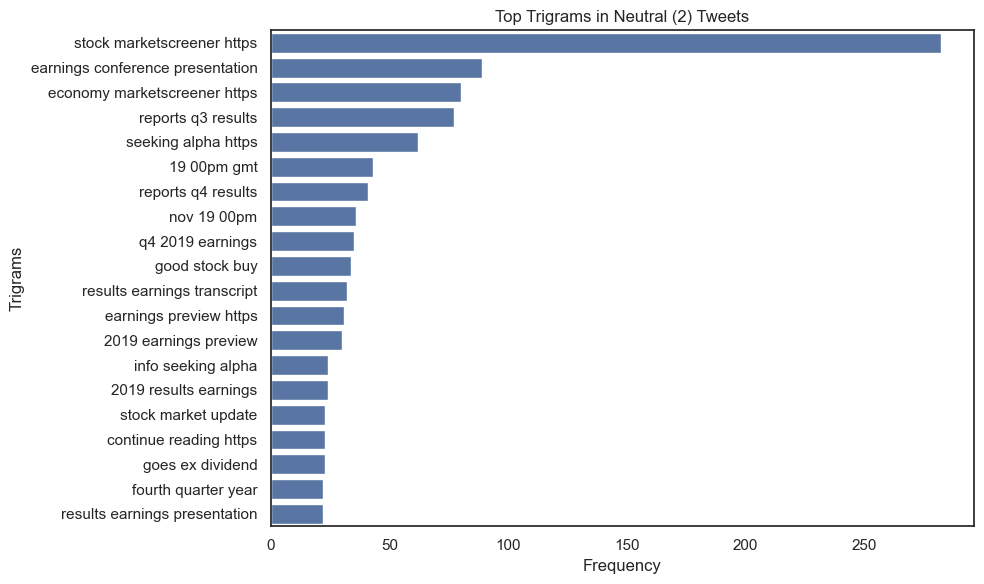

In [36]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

In [37]:
# Function to get top TF-IDF terms
def get_top_tfidf_terms(corpus, top_n=20, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    X = tfidf.fit_transform(corpus)
    scores = X.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': scores})
    top_terms = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return top_terms

In [38]:
# Function to plot top TF-IDF terms
def plot_top_tfidf_terms(tfidf_df, title='Top TF-IDF Terms'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='term', data=tfidf_df)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

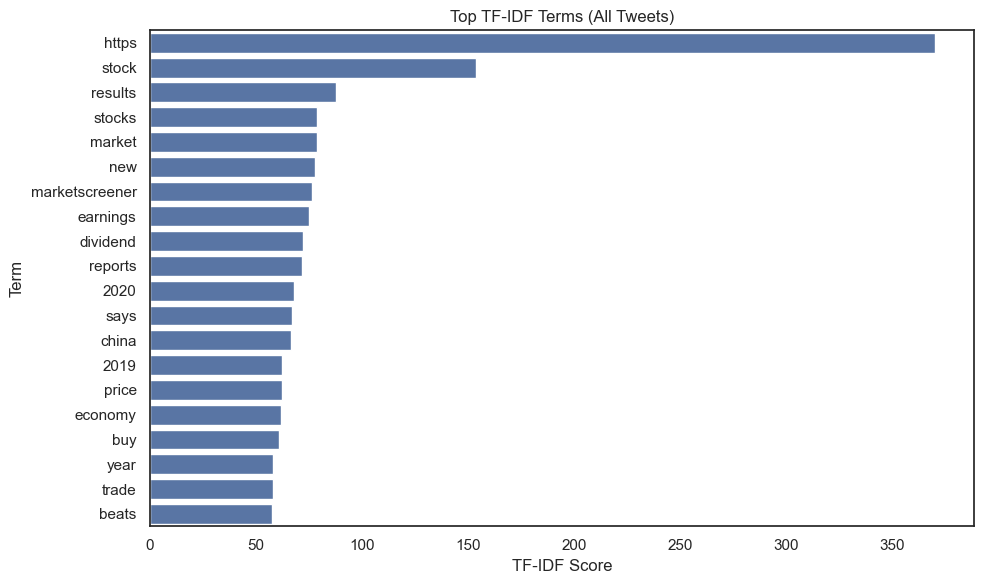

In [39]:
global_tfidf = get_top_tfidf_terms(df_train['text'].str.lower(), top_n=20)
plot_top_tfidf_terms(global_tfidf, title='Top TF-IDF Terms (All Tweets)')

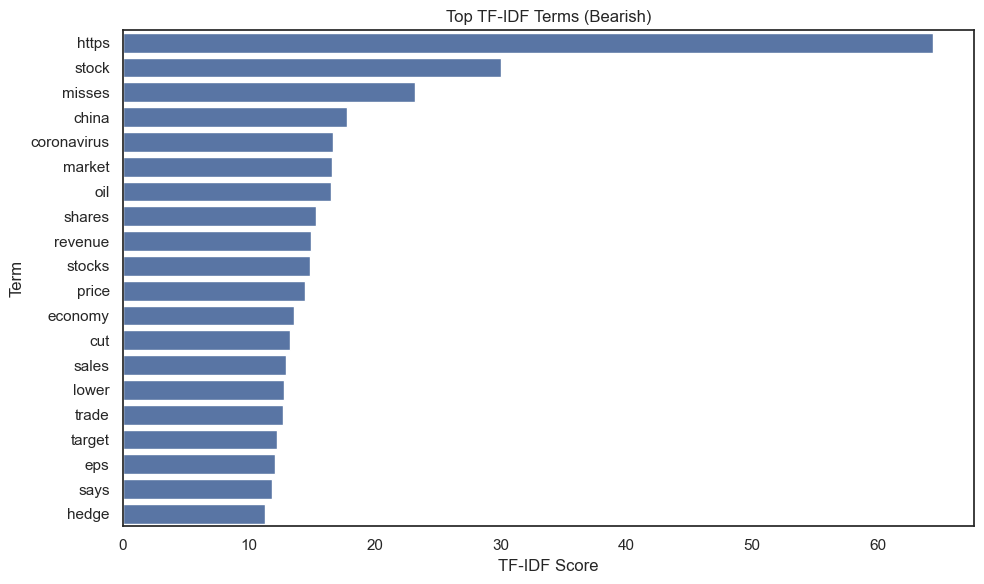

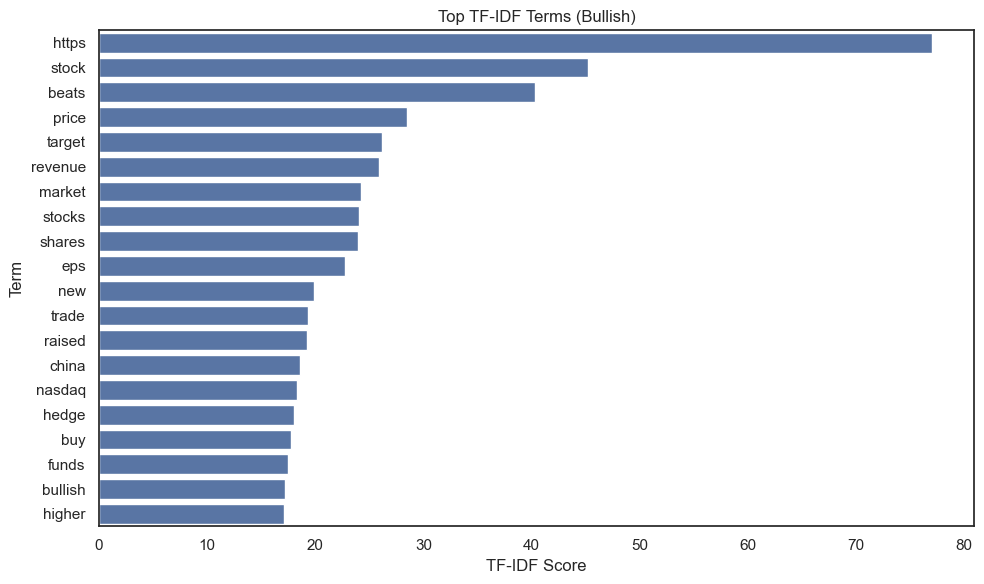

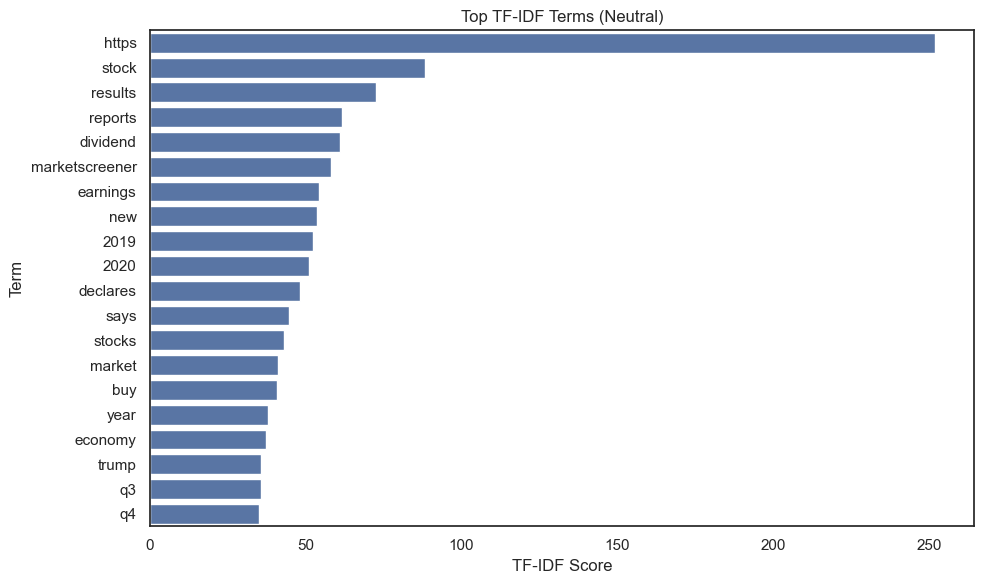

In [40]:
# Bearish (0)
bearish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 0]['text'].str.lower())
plot_top_tfidf_terms(bearish_tfidf, title='Top TF-IDF Terms (Bearish)')

# Bullish (1)
bullish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 1]['text'].str.lower())
plot_top_tfidf_terms(bullish_tfidf, title='Top TF-IDF Terms (Bullish)')

# Neutral (2)
neutral_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 2]['text'].str.lower())
plot_top_tfidf_terms(neutral_tfidf, title='Top TF-IDF Terms (Neutral)')

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.20, random_state=4, stratify=df_train['label'])

In [42]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7634, 1909, 7634, 1909)

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

In [43]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [45]:
def preprocess_text(text, do_lemmatize=True, do_stem=False):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)                            # Remove mentions and hashtags
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)     # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenization
    tokens = nltk.word_tokenize(text)

    # 4. Stop word removal
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization and Stemming
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if do_stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

In [46]:
X_train_cleaned = X_train.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))
X_test_cleaned = X_test.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))

In [47]:
# Check before and after cleaning
print("Original tweet:\n", X_train.iloc[6])
print("Cleaned tweet:\n", X_train_cleaned.iloc[6])

Original tweet:
 Hedge Funds Open Kimono: 5 Most Popular Software Stocks Right Now
Cleaned tweet:
 hedge fund open kimono popular software stock right


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [48]:
def extract_bow_features(train_texts, test_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer

In [49]:
BoW_X_train, BoW_X_test, bow_vectorizer = extract_bow_features(X_train_cleaned, X_test_cleaned)

In [50]:
term_counts = np.array(BoW_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [51]:
top_terms_df.head(10)

,term,count
10475,stock,673
6577,market,318
9640,say,317
9185,report,317
7332,new,313
8606,price,300
9259,result,300
3344,earnings,281
9896,share,277
5341,inc,256


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [52]:
def extract_tfidf_features(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()
    return X_train, X_test, vectorizer

In [53]:
tfidf_X_train, tfidf_X_test, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_test_cleaned)

In [54]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('fighter', 8.841885928984624),
 ('fighting', 9.247351037092788),
 ('figrx', 9.247351037092788),
 ('figure', 8.148738748424677),
 ('figured', 9.247351037092788),
 ('file', 7.107284873596517),
 ('filed', 8.148738748424677),
 ('filer', 9.247351037092788),
 ('filing', 8.554203856532842),
 ('fill', 8.841885928984624)]

<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [55]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [56]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_test = [text.split() for text in X_test_cleaned]

In [57]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [58]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Transformer (BERT)

</a>

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embed(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state[:,0,:].detach().numpy()


<a class="anchor" id="sub-section-5_5"></a>

## 5.5. Extra method 1

</a>

Meta/Facebook pre-trained English word-vector model

In [ ]:
import fasttext
import fasttext.util

# cc.en.300.bin from https://fasttext.cc/docs/en/english-vectors.html
ft = fasttext.load_model('cc.en.300.bin')

def get_avg_fasttext(texts, model):
    features = []
    for text in texts:
        words = text.split()
        # fasttext returns a vector even for OOV words via subword n-grams
        word_vecs = [model.get_word_vector(w) for w in words]
        if word_vecs:
            features.append(np.mean(word_vecs, axis=0))
        else:
            features.append(np.zeros(model.get_dimension()))
    return np.array(features)

# Apply to your cleaned splits
fasttext_X_train = get_avg_fasttext(X_train_cleaned, ft)
fasttext_X_test  = get_avg_fasttext(X_test_cleaned, ft)


<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Extra method 2

</a>

Sentence-Transformer (SBERT) for Financial Sentences

https://huggingface.co/ohsuz/k-finance-sentence-transformer

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

from sentence_transformers import SentenceTransformer

# Load the finance-tuned SBERT
sbert = SentenceTransformer("ohsuz/k-finance-sentence-transformer")

# Encode
sbert_X_train = sbert.encode(X_train.tolist(), show_progress_bar=True)
sbert_X_test  = sbert.encode(X_test.tolist(),  show_progress_bar=True)

In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. KNN

</a>

In [59]:
# For evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

**WITH BOW**

In [60]:
BoW_knn = KNeighborsClassifier(n_neighbors=5)
BoW_knn.fit(BoW_X_train, y_train)
y_pred = BoW_knn.predict(BoW_X_test)

In [61]:
evaluate_classification("BoW", y_test, y_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7077003666841278
Precision (macro): 0.7168072435368033
Recall (macro): 0.44217791741384116
F1 Score (macro): 0.45701743022468005

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7308    0.1372    0.2310       277
           1     0.7130    0.2037    0.3169       378
           2     0.7067    0.9856    0.8232      1254

    accuracy                         0.7077      1909
   macro avg     0.7168    0.4422    0.4570      1909
weighted avg     0.7114    0.7077    0.6370      1909



**WITH TF-IDF**

In [62]:
tfidf_knn = KNeighborsClassifier(n_neighbors=5)
tfidf_knn.fit(tfidf_X_train, y_train)
y_pred = tfidf_knn.predict(tfidf_X_test)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ruben\.conda\envs\DeepLearnin

In [63]:
evaluate_classification("TF-IDF", y_test, y_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.6856993190151912
Precision (macro): 0.7722433702825859
Recall (macro): 0.39038040469416746
F1 Score (macro): 0.3741693997379148

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.8095    0.0614    0.1141       277
           1     0.8269    0.1138    0.2000       378
           2     0.6803    0.9960    0.8084      1254

    accuracy                         0.6857      1909
   macro avg     0.7722    0.3904    0.3742      1909
weighted avg     0.7281    0.6857    0.5872      1909



**WITH WORD2VEC**

In [64]:
word2vec_knn = KNeighborsClassifier(n_neighbors=5)
word2vec_knn.fit(word2vec_X_train, y_train)
y_pred = word2vec_knn.predict(word2vec_X_test)

In [65]:
evaluate_classification("Word2Vec", y_test, y_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.6233630172865374
Precision (macro): 0.4590455948017336
Recall (macro): 0.4446484332480913
F1 Score (macro): 0.4494807106193143

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.2308    0.2166    0.2235       277
           1     0.3993    0.3095    0.3487       378
           2     0.7471    0.8078    0.7762      1254

    accuracy                         0.6234      1909
   macro avg     0.4590    0.4446    0.4495      1909
weighted avg     0.6033    0.6234    0.6114      1909



- BoW is currently the best-performing model overall (highest accuracy and decent balance). 
- TF-IDF may be best if prioritize precision (e.g., fewer false alarms).
- Word2Vec might help if you're more concerned with not missing any relevant tweets (higher recall).

**Next steps???**
- Hyperparameter tuning for KNN
- Balancing the dataset or applying class weights?
- Trying other embeddings (e.g. BERT + extra 2 methods for extra points)
- Other classification models: LSTM, Transformer (encoder)
    - 1 extra point for using other transformer encoder and decoder models for classification (1 extra method of each).

## 6.2. LSTM

In [66]:
# !pip install torch
# !pip install datasets
# !pip install transformers
# !pip install evaluate

In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import get_scheduler
import evaluate
from torch.optim import AdamW  # <-- import AdamW from torch.optim

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

In [4]:
import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.layers import (Input, Embedding, SpatialDropout1D, LSTM, 
                                     BatchNormalization, Dropout, Dense)
import numpy as np
import keras
from keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import (Input, Embedding, SpatialDropout1D, LSTM, 
                         BatchNormalization, Dropout, Dense)
from keras.callbacks import (ReduceLROnPlateau, EarlyStopping)
from keras.metrics import CategoricalAccuracy, AUC, F1Score, TopKCategoricalAccuracy
from keras.optimizers import Adam

### Tokenization, Vocabulary Building, and DataLoader Setup for LSTM

In [77]:
### Tokenization and Vocabulary Building
# Build vocabulary from preprocessed training data (already tokenized and cleaned)
def build_vocab(texts, min_freq=2):
    word_counts = Counter()
    for text in texts:
        tokens = text.split()  # Text is already preprocessed, just split on whitespace
        word_counts.update(tokens)
    
    vocab = {'<pad>': 0}
    for word, freq in word_counts.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

# Build vocab from training data
vocab = build_vocab(X_train_cleaned, min_freq=2)

# Convert preprocessed text to token IDs using vocab; unknown tokens mapped to 0
def text_pipeline(text):
    tokens = text.split()  # Text already preprocessed by preprocess_text(), just split
    return [vocab.get(token, 0) for token in tokens]

# Convert texts to sequences of token IDs
X_train_sequences = [text_pipeline(text) for text in X_train_cleaned]
X_test_sequences = [text_pipeline(text) for text in X_test_cleaned]

# Pad sequences to same length
max_length = max(len(seq) for seq in X_train_sequences + X_test_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', value=vocab['<pad>'])
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', value=vocab['<pad>'])

# Convert labels to numpy arrays
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

### Defining the LSTM Model

In [ ]:
def build_LSTM((vocab_size, max_length, num_classes):
    emb_matrix = load_glove_matrix(...)  # load pretrained embeddings
    inp = Input(shape=(max_length,))
    x = Embedding(vocab_size, 100, weights=[emb_matrix], 
                  trainable=False, mask_zero=True)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = GlobalMaxPooling1D()(x)  # or attention
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)
    
    
vocab_size = len(vocab)
embed_dim  = 100
hidden_dim = 128
output_dim = 3

### Hyperparameters and training initialization

In [87]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)
callbacks = [lr_reduction]


In [88]:
f1_score = F1Score(average="macro", name="f1_score")
metrics = [f1_score]

optimizer = Adam(learning_rate= 1e-4, name="optimizer")

In [90]:
### Model Setup

# Model hyperparameters
vocab_size = len(vocab)
num_classes = 3  # Number of classes


# Create advanced model
model = build_simple_lstm(vocab_size, embed_dim, hidden_dim, output_dim)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    #metrics=metrics
)

# Display model architecture
model.summary()

Model: "Simple_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 29, 100)        │       554,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 29, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,235 (2.56 MB)

 Trainable params: 672,235 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [91]:
### Model Training
num_epochs = 30
batch_size = 32

# Train the model
history = model.fit(
    X_train_padded, y_train_array,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_test_padded, y_test_array),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 1.0508 - val_loss: 0.9113 - learning_rate: 1.0000e-04
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.8821 - val_loss: 0.7733 - learning_rate: 1.0000e-04
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.7141 - val_loss: 0.6967 - learning_rate: 1.0000e-04
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6001 - val_loss: 0.6843 - learning_rate: 1.0000e-04
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5450 - val_loss: 0.6747 - learning_rate: 1.0000e-04
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5030 - val_loss: 0.7094 - learning_rate: 1.0000e-04
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4582 - val_loss: 0.7211 - learning_rate: 1.0000e-04
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4262 - val_loss: 0.7623 - learning_rate: 1.0000e-04
Epoch 9/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3912 - val_loss: 0.7

### Evaluation

In [93]:
### Evaluation
# model.eval() # Not needed in Keras
all_preds = []
all_labels = []

# Make predictions in batches like PyTorch
for i in range(0, len(X_test_padded), batch_size):
    batch_X = X_test_padded[i:i+batch_size]
    batch_y = y_test_array[i:i+batch_size]
    
    outputs = model.predict(batch_X, verbose=0)
    preds = np.argmax(outputs, axis=1)
    
    all_preds.extend(preds)
    all_labels.extend(batch_y)

evaluate_classification("Keras LSTM", all_labels, all_preds)

Evaluation metrics with Keras LSTM features.
Accuracy: 0.7574646411733892
Precision (macro): 0.6729790437488282
Recall (macro): 0.6432754173903076


TypeError: FBetaScore.update_state() got an unexpected keyword argument 'average'

## Transformer

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW

import evaluate

# Use pretrained DistilBERT tokenizer (uncased)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load DistilBERT model with sequence classification head (3 classes)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)




c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ruben\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regul

### Transformers

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() if hasattr(texts, "tolist") else texts
        self.labels = labels.tolist() if hasattr(labels, "tolist") else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create Dataset and DataLoader objects for train and test
train_dataset = TransformerDataset(X_train_cleaned, y_train, tokenizer)
test_dataset = TransformerDataset(X_test_cleaned, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

### Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained DistilBERT model with classification head for 3 classes
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

metric = evaluate.load("accuracy")


### Training

In [ ]:
for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")



Epoch 1: Train Loss=0.2614, Val Loss=0.4890
Epoch 2: Train Loss=0.1403, Val Loss=0.5345
Epoch 3: Train Loss=0.1273, Val Loss=0.5345


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

evaluate_classification("Transformer", all_labels, all_preds)



Evaluation metrics with Transformer features.
Accuracy: 0.8334206390780513
Precision (macro): 0.7748282497672694
Recall (macro): 0.7639447108697853
F1 Score (macro): 0.7691675824804817

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6850    0.6751    0.6800       277
           1     0.7514    0.7116    0.7310       378
           2     0.8881    0.9051    0.8965      1254

    accuracy                         0.8334      1909
   macro avg     0.7748    0.7639    0.7692      1909
weighted avg     0.8316    0.8334    0.8323      1909



In [ ]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings
import pandas as 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer, PorterStemmer
import gensim
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
# Set the style for seaborn
sns.set(style="white")
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')
<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>
# Check the test set
print(df_test.shape)
df_test.head()
# Set id as index
df_test.set_index('id', inplace=True)
# Check the train set
print(df_train.shape)
df_train.head()
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")
<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>
df_train["label"].value_counts()
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()
sns.boxplot(data=df_train['label'])
<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>
# Fetch wordcount for each abstract
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()
df_train.word_count.describe()
# Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()
<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()
All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()
# Simple text cleaner
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # keep only letters
    return text

# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')
# Create a character count column
df_train['char_count'] = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))
# Function to get top TF-IDF terms
def get_top_tfidf_terms(corpus, top_n=20, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    X = tfidf.fit_transform(corpus)
    scores = X.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': scores})
    top_terms = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return top_terms
# Function to plot top TF-IDF terms
def plot_top_tfidf_terms(tfidf_df, title='Top TF-IDF Terms'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='term', data=tfidf_df)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()
global_tfidf = get_top_tfidf_terms(df_train['text'].str.lower(), top_n=20)
plot_top_tfidf_terms(global_tfidf, title='Top TF-IDF Terms (All Tweets)')
# Bearish (0)
bearish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 0]['text'].str.lower())
plot_top_tfidf_terms(bearish_tfidf, title='Top TF-IDF Terms (Bearish)')

# Bullish (1)
bullish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 1]['text'].str.lower())
plot_top_tfidf_terms(bullish_tfidf, title='Top TF-IDF Terms (Bullish)')

# Neutral (2)
neutral_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 2]['text'].str.lower())
plot_top_tfidf_terms(neutral_tfidf, title='Top TF-IDF Terms (Neutral)')
<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.20, random_state=4)
len(X_train), len(X_test), len(y_train), len(y_test)
<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def preprocess_text(text, do_lemmatize=True, do_stem=False):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)                            # Remove mentions and hashtags
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)     # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenization
    tokens = nltk.word_tokenize(text)

    # 4. Stop word removal
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization and Stemming
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if do_stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)
X_train_cleaned = X_train.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))
X_test_cleaned = X_test.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))
# Check before and after cleaning
print("Original tweet:\n", X_train.iloc[6])
print("Cleaned tweet:\n", X_train_cleaned.iloc[6])
<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>
<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>
def extract_bow_features(train_texts, test_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer
BoW_X_train, BoW_X_test, bow_vectorizer = extract_bow_features(X_train_cleaned, X_test_cleaned)
term_counts = np.array(BoW_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)
top_terms_df.head(10)
<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>
def extract_tfidf_features(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()
    return X_train, X_test, vectorizer
tfidf_X_train, tfidf_X_test, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_test_cleaned)
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]
<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_test = [text.split() for text in X_test_cleaned]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)
<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Transformer (BERT)

</a>
<a class="anchor" id="sub-section-5_5"></a>

## 5.5. Extra method 1

</a>
<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Extra method 2

</a>
<a class="anchor" id="chapter6"></a>

# 6. Models

</a>
<a class="anchor" id="sub-section-6_1"></a>

## 6.1. KNN

</a>
# For evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))
**WITH BOW**
BoW_knn = KNeighborsClassifier(n_neighbors=5)
BoW_knn.fit(BoW_X_train, y_train)
y_pred = BoW_knn.predict(BoW_X_test)
evaluate_classification("BoW", y_test, y_pred)
**WITH TF-IDF**
tfidf_knn = KNeighborsClassifier(n_neighbors=5)
tfidf_knn.fit(tfidf_X_train, y_train)
y_pred = tfidf_knn.predict(tfidf_X_test)
evaluate_classification("TF-IDF", y_test, y_pred)
**WITH WORD2VEC**
word2vec_knn = KNeighborsClassifier(n_neighbors=5)
word2vec_knn.fit(word2vec_X_train, y_train)
y_pred = word2vec_knn.predict(word2vec_X_test)
evaluate_classification("Word2Vec", y_test, y_pred)
- BoW is currently the best-performing model overall (highest accuracy and decent balance). 
- TF-IDF may be best if prioritize precision (e.g., fewer false alarms).
- Word2Vec might help if you're more concerned with not missing any relevant tweets (higher recall).
**Next steps???**
- Hyperparameter tuning for KNN
- Balancing the dataset or applying class weights?
- Trying other embeddings (e.g. BERT + extra 2 methods for extra points)
- Other classification models: LSTM, Transformer (encoder)
    - 1 extra point for using other transformer encoder and decoder models for classification (1 extra method of each).
## 6.2. Pytorch
# !pip install torch
# !pip install datasets
# !pip install transformers
# !pip install evaluate
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import get_scheduler
import evaluate
from torch.optim import AdamW  # <-- import AdamW from torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

### Preparation
# Simple tokenizer splitting text into lowercase words using regex
def basic_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocab from training data tokens, while ignoring tokens with a frequency < 2
counter = Counter()
for text in X_train_cleaned:
    counter.update(basic_tokenizer(text))

# Map tokens to unique IDs, 0 is reserved for padding
vocab = {word: idx + 1 for idx, (word, freq) in enumerate(counter.items()) if freq >= 2}
vocab['<pad>'] = 0

# Convert text to list of token IDs, unknown tokens become 0 (padding)
def text_pipeline(text):
    return [vocab.get(token, 0) for token in basic_tokenizer(text)]

# Custom Dataset returning tokenized text and label tensors
class LSTMDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist() if hasattr(texts, 'tolist') else texts
        self.labels = labels.tolist() if hasattr(labels, 'tolist') else labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = torch.tensor(text_pipeline(self.texts[idx]), dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return tokens, label

# Collate function to pad sequences to max length in batch
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.stack(labels)
    return texts_padded, labels

# Create Dataset and DataLoader objects for train and test
train_dataset = LSTMDataset(X_train_cleaned, y_train)
test_dataset = LSTMDataset(X_test_cleaned, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_batch)



import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super().__init__()
        # Embedding layer: maps token IDs to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # LSTM layer: processes sequences of embeddings
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer to produce logits for each class
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Embed tokens
        embedded = self.dropout(self.embedding(x))
        
        # Pass embeddings through LSTM
        lstm_out, _ = self.lstm(embedded)
        
        # Take output from last timestep
        last_hidden = lstm_out[:, -1, :]
        
        # Fully connected layer for class logits
        output = self.fc(last_hidden)
        
        return output

# Model hyperparameters
vocab_size = max(vocab.values()) + 1

embed_dim = 100
hidden_dim = 128
output_dim = 3  # Number of classes (Bearish, Bullish, Neutral)

# Instantiate model
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


SyntaxError: invalid character '–' (U+2013) (1817316621.py, line 109)